In [1]:
pip install opencv-python opencv-python-headless numpy matplotlib


   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.9 MB ? eta -:--:--
    --------------------------------------- 0.5/38.9 MB 2.4 MB/s eta 0:00:17
   - -------------------------------------- 1.0/38.9 MB 1.9 MB/s eta 0:00:20
   - -------------------------------------- 1.6/38.9 MB 2.1 MB/s eta 0:00:18
   -- ------------------------------------- 2.1/38.9 MB 2.3 MB/s eta 0:00:17
   -- ------------------------------------- 2.9/38.9 MB 2.6 MB/s eta 0:00:14
   ---- ----------------------------------- 4.2/38.9 MB 3.1 MB/s eta 0:00:12
   ----- ---------------------------------- 5.2/38.9 MB 3.4 MB/s eta 0:00:10
   ------ --------------------------------- 6.6/38.9 MB 3.7 MB/s eta 0:00:09
   -------- ------------------------------- 7.9/38.9 MB 4.1 MB/s eta 0:00:08
   --------- ------------------------------ 9.2/38.9 MB 4.3 MB/s eta 0:00:07
   ---------- ----------------------------- 10.5/38.9 MB 4.5 MB/s eta 0:00:07
   ---------

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
from threading import Thread

In [2]:


# Load YOLOv4
net = cv2.dnn.readNet(r"C:\Users\admin\OneDrive\Documents\New folder\yolov4.weights",
                      r"C:\Users\admin\OneDrive\Documents\New folder\yolov4 (1).cfg")


In [3]:
# Load COCO classes
with open("coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]

colors = np.random.uniform(0, 255, size=(len(classes), 3))


In [4]:
# Get output layers
layer_names = net.getLayerNames()
outs = net.getUnconnectedOutLayers()
if len(outs.shape) == 1:
    output_layers = [layer_names[i - 1] for i in outs]
else:
    output_layers = [layer_names[i[0] - 1] for i in outs]


In [5]:
# Start webcam
cap = cv2.VideoCapture(0)

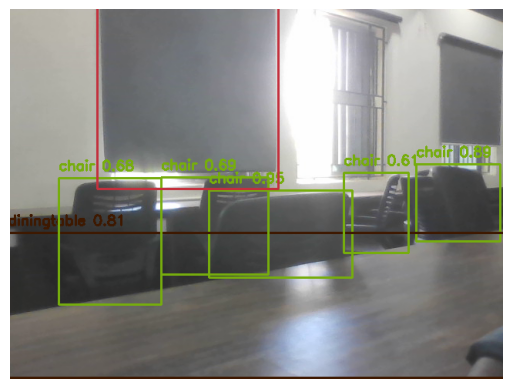

In [ ]:

# Create a stop button
stop_button = widgets.Button(description="Stop Detection", button_style='danger')
display(stop_button)
stop_flag = False

def stop_detection(b):
    global stop_flag
    stop_flag = True

stop_button.on_click(stop_detection)

def detect_objects():
    global stop_flag
    while not stop_flag:
        ret, frame = cap.read()
        if not ret:
            break
        height, width, channels = frame.shape

        # Prepare blob and forward pass
        blob = cv2.dnn.blobFromImage(frame, 1/255.0, (416, 416), swapRB=True, crop=False)
        net.setInput(blob)
        outs = net.forward(output_layers)

        class_ids, confidences, boxes = [], [], []

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > 0.5:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)

        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

        for i in indexes.flatten() if len(indexes) > 0 else []:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[class_ids[i]]
            cv2.rectangle(frame, (x, y), (x + w, y + h), color, 2)
            cv2.putText(frame, f"{label} {confidences[i]:.2f}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        # Display frame inline
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        clear_output(wait=True)
        plt.imshow(frame_rgb)
        plt.axis('off')
        display(plt.gcf())

# Run detection in a separate thread so the stop button works
thread = Thread(target=detect_objects)
thread.start()
